In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%qtconsole

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ripple_detection.simulate import simulate_LFP, simulate_time

In [5]:
SAMPLING_FREQUENCY = 1000
n_samples = SAMPLING_FREQUENCY * 3
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
lfp = simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5)

Visualize ripple filter

Text(0.5,1,'Filter Kernel')

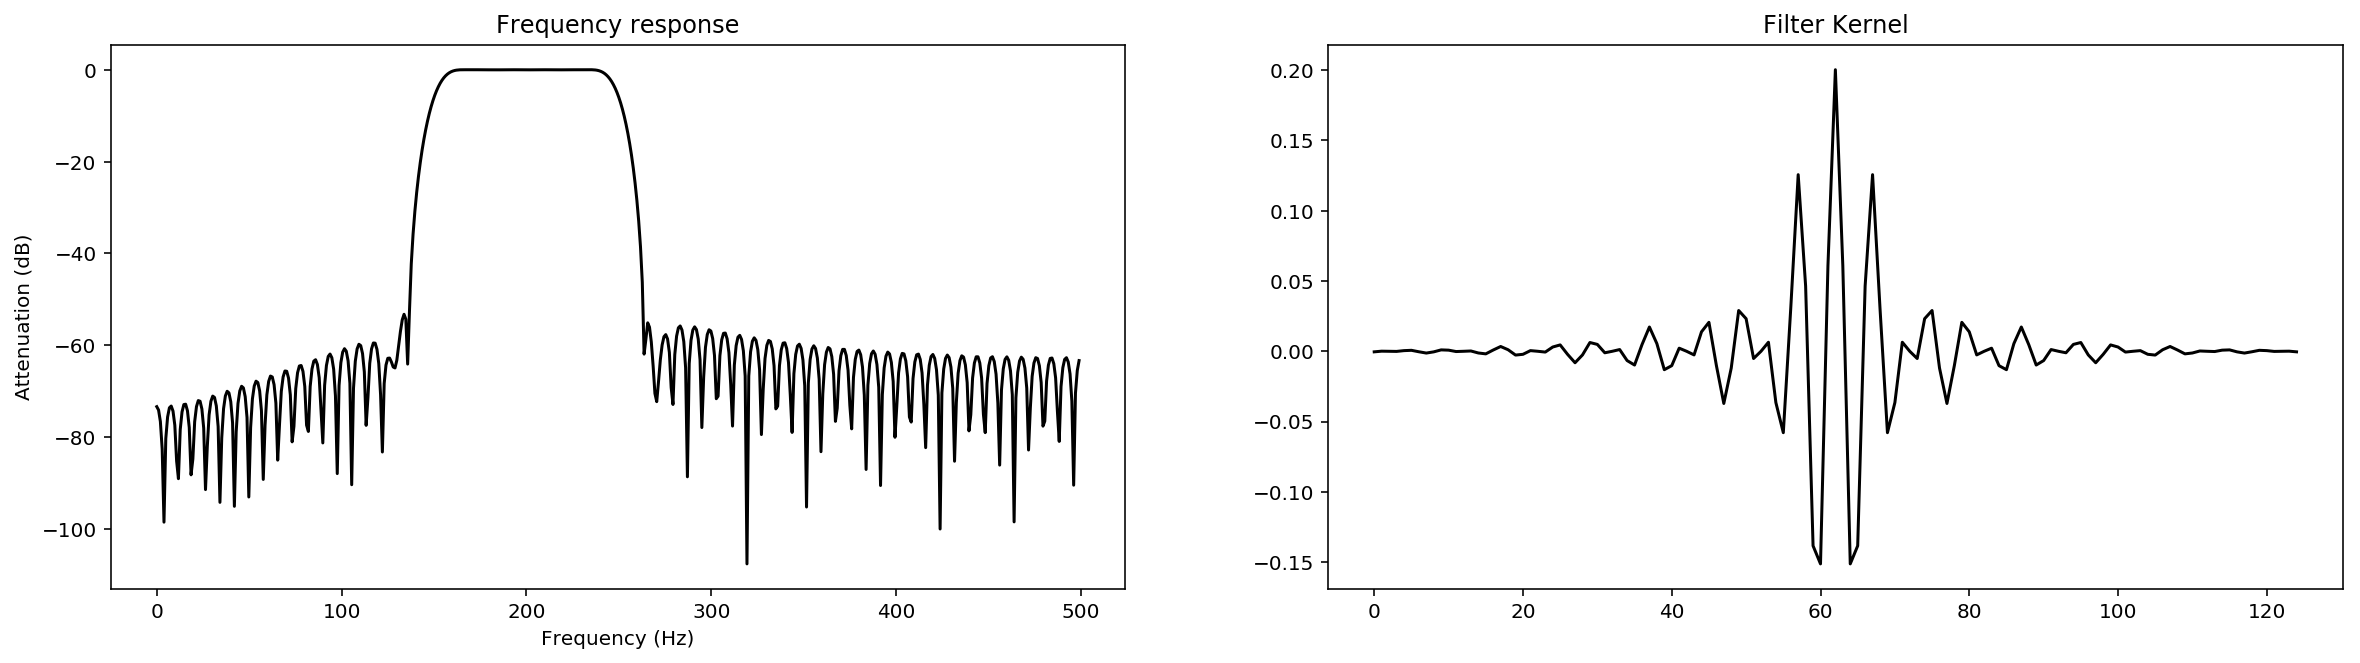

In [88]:
from ripple_detection.core import fir
import scipy.signal

RIPPLE_BAND = [150, 250]
kernel = fir(RIPPLE_BAND, SAMPLING_FREQUENCY, order=125)

normalized_frequency, h = scipy.signal.freqz(kernel, 1.0)
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(normalized_frequency * SAMPLING_FREQUENCY / (2. * np.pi),
         20 * np.log10(np.abs(h)), color='black')
plt.title('Frequency response')
plt.ylabel('Attenuation (dB)')
plt.xlabel('Frequency (Hz)');

plt.subplot(1, 2, 2)
plt.plot(kernel, color='black')
plt.title('Filter Kernel')

## Karlsson Method

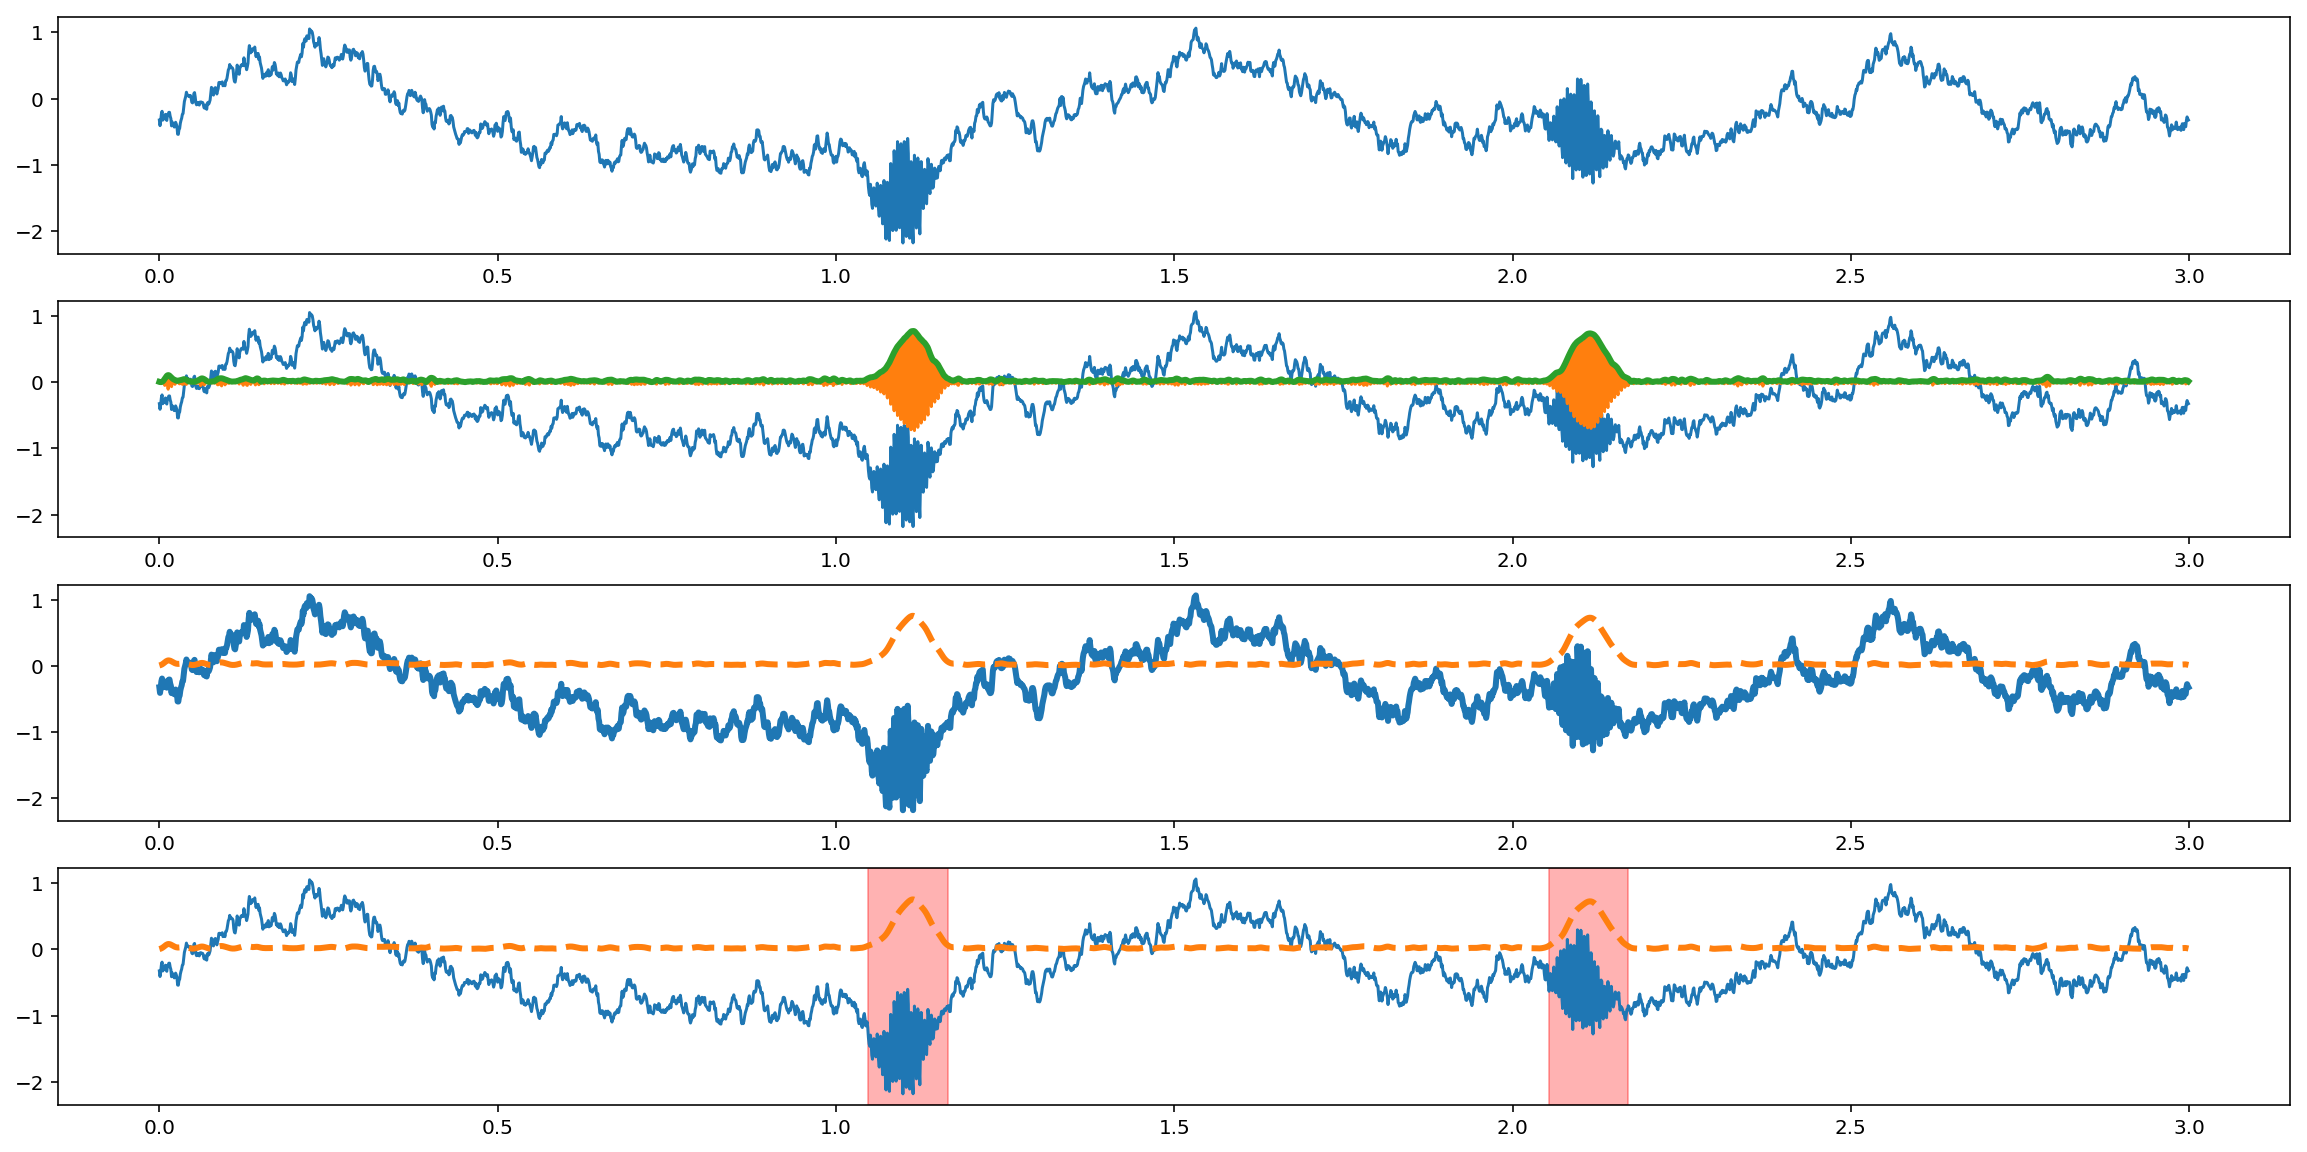

In [78]:
from ripple_detection.core import (ripple_bandpass_filter, get_envelope,
                                   gaussian_smooth, threshold_by_zscore)

smoothing_sigma = 0.004
minimum_duration = 0.015
zscore_threshold = 3

is_nan = np.isnan(lfp)
filtered_lfp = ripple_bandpass_filter(
    lfp[~is_nan].squeeze(), sampling_frequency=SAMPLING_FREQUENCY)
envelope = get_envelope(filtered_lfp)
smoothed_envelope = gaussian_smooth(
    envelope, sigma=smoothing_sigma,
    sampling_frequency=SAMPLING_FREQUENCY)

lfp_ripple_times = threshold_by_zscore(
    smoothed_envelope, time[~is_nan], minimum_duration,
    zscore_threshold)

fig, ax = plt.subplots(4, 1, figsize=(20, 10))
ax[0].plot(time, lfp);
ax[1].plot(time, lfp);
ax[1].plot(time, filtered_lfp);
ax[1].plot(time, envelope, linewidth=3)
ax[2].plot(time, lfp, linewidth=3)
ax[2].plot(time, smoothed_envelope, linestyle='--', linewidth=3);
ax[3].plot(time, lfp);
ax[3].plot(time, smoothed_envelope, linestyle='--', linewidth=3);
for start_time, end_time in lfp_ripple_times:
    ax[3].axvspan(start_time, end_time, alpha=0.3, color='red')

## Kay Method

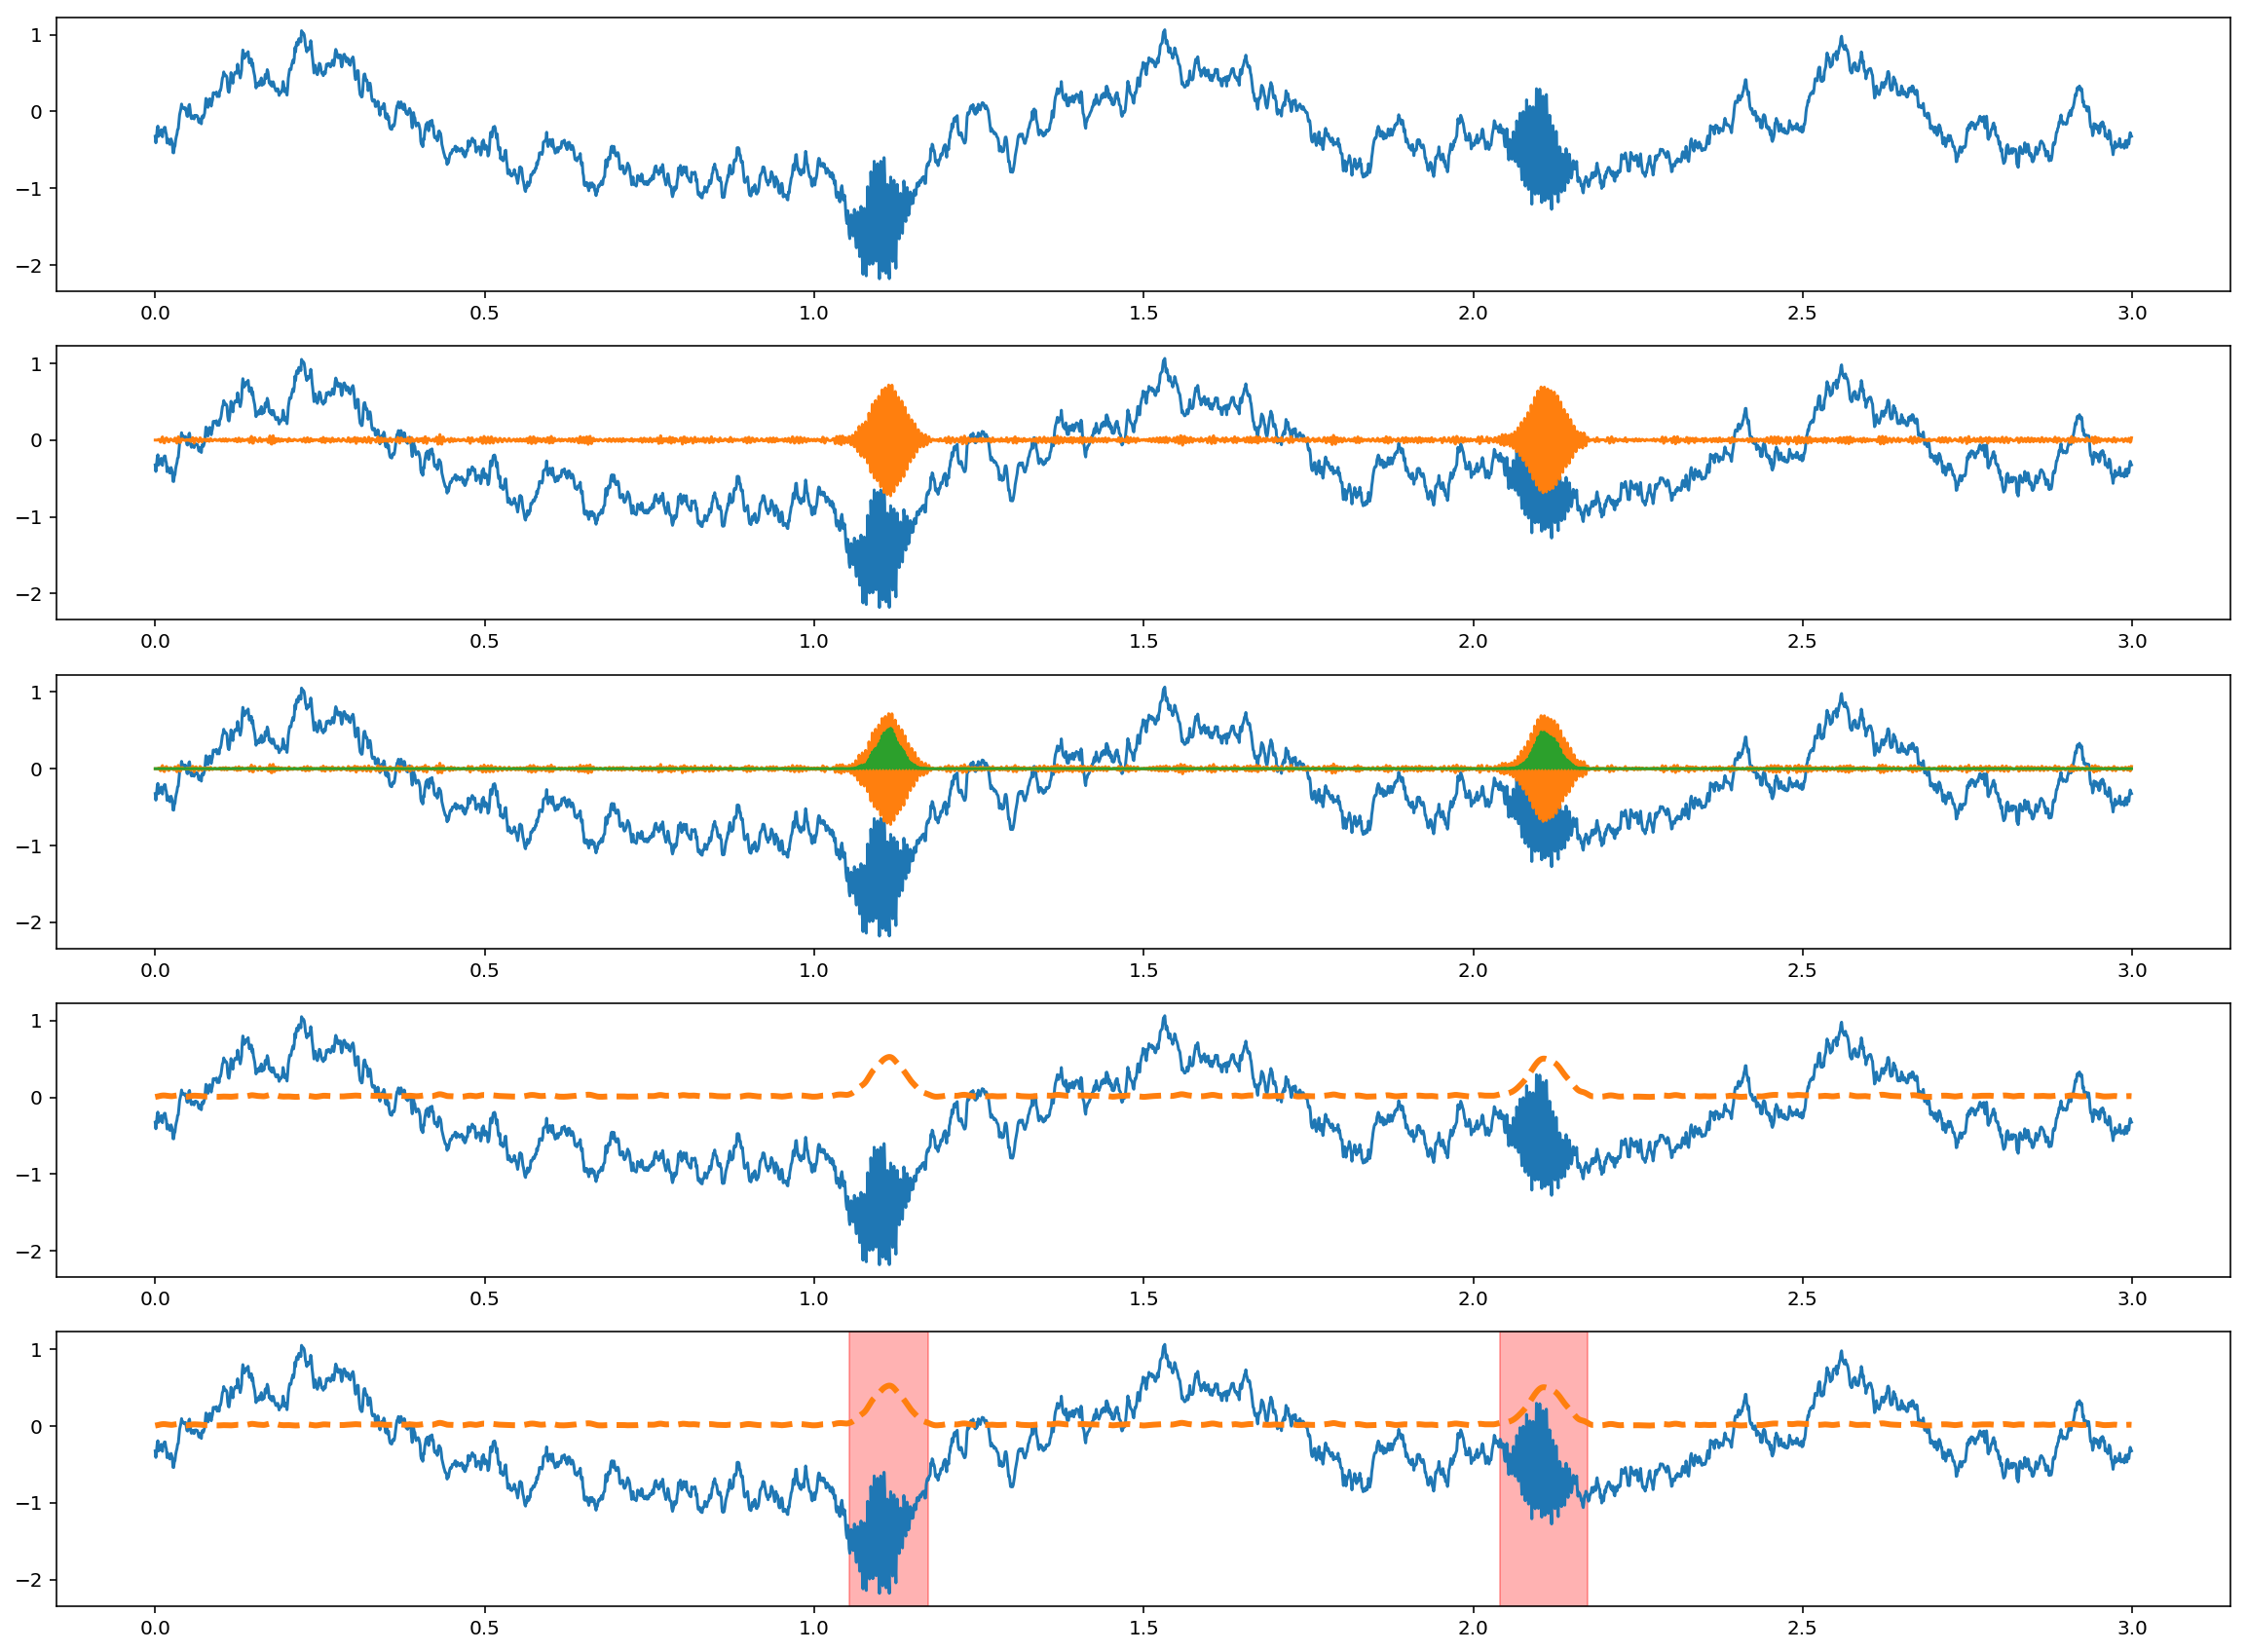

In [84]:
smoothing_sigma = 0.004
minimum_duration = 0.015
zscore_threshold = 3

filtered_lfps = [
    ripple_bandpass_filter(lfp[~np.isnan(lfp)].squeeze(),
                           sampling_frequency=SAMPLING_FREQUENCY)
    for lfp in LFPs.T]

sum_squared_filtered_lfps = np.nansum(filtered_lfps, axis=0) ** 2
combined_filtered_lfps = np.sqrt(
    gaussian_smooth(sum_squared_filtered_lfps,
                    sigma=smoothing_sigma,
                    sampling_frequency=SAMPLING_FREQUENCY))
candidate_ripple_times = threshold_by_zscore(
    combined_filtered_lfps, time, minimum_duration, zscore_threshold)


fig, ax = plt.subplots(5, 1, figsize=(20, 15))
ax[0].plot(time, lfp);
ax[1].plot(time, lfp);
ax[1].plot(time, filtered_lfps[0]);
ax[2].plot(time, lfp);
ax[2].plot(time, filtered_lfps[0]);
ax[2].plot(time, sum_squared_filtered_lfps)
ax[3].plot(time, lfp);
ax[3].plot(time, combined_filtered_lfps, linestyle='--', linewidth=3)
ax[4].plot(time, lfp);
ax[4].plot(time, combined_filtered_lfps, linestyle='--', linewidth=3)
for start_time, end_time in candidate_ripple_times:
    ax[4].axvspan(start_time, end_time, alpha=0.3, color='red')